In [1]:
from eventvision import read_dataset, read_annotation

import os
import cv2
import glob
import time
import numpy as np
import contextlib
import torch.cuda.amp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import spconv.pytorch as spconv
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F

from BoundingBoxRegressionUtils import parse_partial_dataset, parse_random_dataset, torch_iou


POINTS = 500

Event-based vision module imported


In [2]:
def getData(filename):
    td = read_dataset(filename)
    
    width = td.width
    height = td.height
    
    points = np.column_stack((td.data.x[:POINTS], td.data.y[:POINTS]))
    
    return width, height, np.array(points).reshape(POINTS, 2, 1)

def getAnnotation(filename):
    data = read_annotation(filename)
    minX = min(data[0])
    maxX = max(data[0])
    minY = min(data[1])
    maxY = max(data[1])
    
    return minX, minY, maxX, maxY

In [3]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    amp_ctx = contextlib.nullcontext()
    if args.fp16:
        amp_ctx = torch.cuda.amp.autocast()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        with amp_ctx:
            output = model(data)
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
            
            correct += torch.sum(torch_iou(output[:, -4:], target[:, -4:]))
            
    return correct / len(train_loader.dataset)

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    amp_ctx = contextlib.nullcontext()
    if args.fp16:
        amp_ctx = torch.cuda.amp.autocast()

    with torch.no_grad():
        for data, target in test_loader:

            data, target = data.to(device), target.to(device)
            with amp_ctx:

                output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item() # sum up batch loss
            
            correct += torch.sum(torch_iou(output[:, -4:], target[:, -4:]))
            

    test_loss /= len(test_loader.dataset)

    
    return correct / len(test_loader.dataset)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = spconv.SparseSequential(
            spconv.SparseConv2d(1, 16, 5, stride=1, padding=2),
            nn.LeakyReLU(0.1),
            spconv.SparseMaxPool2d(2, 2),
            
            spconv.SparseConv2d(16, 32, 5, stride=1, padding=2),
            nn.LeakyReLU(0.1),
            spconv.SparseMaxPool2d(2, 2, 1),
            
            spconv.SparseConv2d(32, 64, 5, stride=1, padding=2),
            nn.LeakyReLU(0.1),
            spconv.SparseMaxPool2d(2, 2, 1),
            
            spconv.SparseConv2d(64, 128, 5, stride=1, padding=2),
            nn.LeakyReLU(0.1),
            spconv.SparseMaxPool2d(2, 2, (0,1)),
            
            spconv.SparseConv2d(128, 256, 5, stride=1, padding=2),
            nn.LeakyReLU(0.1),
            spconv.SparseMaxPool2d(2, 2, (0,1)),
            
            spconv.ToDense(),
            nn.Flatten(1,-1),
            nn.Dropout(p=0.2),
            nn.Linear(4096, 2048),
            nn.Linear(2048, 1024),
            nn.Linear(1024, 8),
        )

    def forward(self, x: torch.Tensor):
        x = spconv.SparseConvTensor.from_dense(x.reshape(-1, POINTS, 2, 1))
        y =  self.net(x)
        
        return y

In [5]:
X_train, X_test, y_train, y_test = parse_partial_dataset(getData, getAnnotation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_loader = torch.utils.data.DataLoader(
    [[X_train[i], y_train[i]] for i in range(len(X_train))], shuffle=False, batch_size=40)
# test_loader = torch.utils.data.DataLoader(
#     [[X_test[i], y_test[i]] for i in range(len(X_test))], shuffle=False, batch_size=40)

args = lambda: None
args.fp16 = True
args.lr = 0.001
args.log_interval = 50

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

def makeTestData():
    testData = []
    
    for i in range(10): 
        X_test, y_test = parse_random_dataset(getData, getAnnotation, True)
        test_loader = torch.utils.data.DataLoader(
            [[X_test[i], y_test[i]] for i in range(len(X_test))], shuffle=False, batch_size=40)
        
        testData.append(test_loader)
        
    return testData

def testTiming(model, testData):
    total_time = 0.0
    total_acc = 0.0
    for i in range(10): 
        test_loader = testData[i]

        testing_time = time.time()

        iou = test(args, model, device, test_loader)

        time_taken = time.time()  - testing_time

        total_time += time_taken
        total_acc += iou

        print("\tFor this mini round, time: ", time_taken, " iou ", iou)

    avg_time = total_time / 10
    avg_acc = total_acc / 10
    
    print("Time on avg: ", avg_time, " IOU on avg: ", avg_acc)
    
    return avg_time, avg_acc

def trainModel():
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    
    train_start_time = time.process_time()

    for epoch in range(0, 40):
        train(args, model, device, train_loader, optimizer, epoch)

    train_time = time.process_time() - train_start_time
    
    print("Training done!  " + str(train_time))
    
    return train_time, model

def getResults():
    testData = makeTestData()
    
    train_timing_results = np.empty(20)
    test_timing_results = np.empty(20)
    test_acc_results = np.empty(20)

    for i in range(20):
        print("Round ", i)

        train_time, model = trainModel()
        train_timing_results[i] = train_time
        
        test_time, test_acc = testTiming(model, testData)
        test_timing_results[i] = test_time
        test_acc_results[i] = test_acc

    print("\n\nTesting done!\n")

    print("Training time: ", np.mean(train_timing_results))
    print("Testing time: ", np.mean(test_timing_results))
    print("Testing acc: ", np.mean(test_acc_results))
    
    return train_timing_results, test_timing_results, test_acc_results

getResults()

cuda:0
Round  0
Training done!  28.328125
	For this mini round, time:  0.3719673156738281  iou  tensor(0.7143, device='cuda:0')
	For this mini round, time:  0.34599947929382324  iou  tensor(0.6993, device='cuda:0')
	For this mini round, time:  0.3419520854949951  iou  tensor(0.7116, device='cuda:0')
	For this mini round, time:  0.36402463912963867  iou  tensor(0.7139, device='cuda:0')
	For this mini round, time:  0.42200255393981934  iou  tensor(0.7049, device='cuda:0')
	For this mini round, time:  0.48202943801879883  iou  tensor(0.7038, device='cuda:0')
	For this mini round, time:  0.45397114753723145  iou  tensor(0.7053, device='cuda:0')
	For this mini round, time:  0.5039606094360352  iou  tensor(0.7134, device='cuda:0')
	For this mini round, time:  0.5810003280639648  iou  tensor(0.7206, device='cuda:0')
	For this mini round, time:  0.5339982509613037  iou  tensor(0.7080, device='cuda:0')
Time on avg:  0.44009058475494384  IOU on avg:  tensor(0.7095, device='cuda:0')
Round  1
Trai

	For this mini round, time:  0.3899998664855957  iou  tensor(0.7313, device='cuda:0')
	For this mini round, time:  0.40600132942199707  iou  tensor(0.7316, device='cuda:0')
	For this mini round, time:  0.4179999828338623  iou  tensor(0.7319, device='cuda:0')
	For this mini round, time:  0.4220001697540283  iou  tensor(0.7401, device='cuda:0')
	For this mini round, time:  0.42600131034851074  iou  tensor(0.7462, device='cuda:0')
	For this mini round, time:  0.45200061798095703  iou  tensor(0.7358, device='cuda:0')
Time on avg:  0.4018028974533081  IOU on avg:  tensor(0.7364, device='cuda:0')
Round  9
Training done!  25.34375
	For this mini round, time:  0.3820042610168457  iou  tensor(0.7126, device='cuda:0')
	For this mini round, time:  0.37600040435791016  iou  tensor(0.7026, device='cuda:0')
	For this mini round, time:  0.39099979400634766  iou  tensor(0.7177, device='cuda:0')
	For this mini round, time:  0.36296963691711426  iou  tensor(0.7148, device='cuda:0')
	For this mini round,

	For this mini round, time:  0.4100024700164795  iou  tensor(0.6936, device='cuda:0')
Time on avg:  0.383091402053833  IOU on avg:  tensor(0.6950, device='cuda:0')
Round  17
Training done!  24.875
	For this mini round, time:  0.3559989929199219  iou  tensor(0.6951, device='cuda:0')
	For this mini round, time:  0.3509993553161621  iou  tensor(0.6821, device='cuda:0')
	For this mini round, time:  0.36002492904663086  iou  tensor(0.6974, device='cuda:0')
	For this mini round, time:  0.35699892044067383  iou  tensor(0.6973, device='cuda:0')
	For this mini round, time:  0.3789997100830078  iou  tensor(0.6831, device='cuda:0')
	For this mini round, time:  0.40197014808654785  iou  tensor(0.6812, device='cuda:0')
	For this mini round, time:  0.394000768661499  iou  tensor(0.6908, device='cuda:0')
	For this mini round, time:  0.39999985694885254  iou  tensor(0.6952, device='cuda:0')
	For this mini round, time:  0.4089930057525635  iou  tensor(0.6979, device='cuda:0')
	For this mini round, time

(array([28.328125, 25.65625 , 25.734375, 25.546875, 24.96875 , 24.96875 ,
        26.28125 , 25.84375 , 26.28125 , 25.34375 , 24.953125, 25.      ,
        25.109375, 24.96875 , 24.96875 , 24.953125, 25.3125  , 24.875   ,
        24.734375, 24.75    ]),
 array([0.44009058, 0.38188527, 0.43300133, 0.38980222, 0.38749754,
        0.3878006 , 0.4254051 , 0.44565678, 0.4018029 , 0.38980534,
        0.38660328, 0.38549833, 0.38670092, 0.38680513, 0.39310412,
        0.39869688, 0.3830914 , 0.38139856, 0.38519714, 0.40200236]),
 array([0.70951551, 0.72124809, 0.71688187, 0.72312415, 0.69313908,
        0.70995903, 0.71894771, 0.70039403, 0.73640263, 0.71044004,
        0.71590865, 0.69505453, 0.68178248, 0.69407052, 0.72697538,
        0.71286529, 0.69499123, 0.69131559, 0.71445733, 0.71491903]))

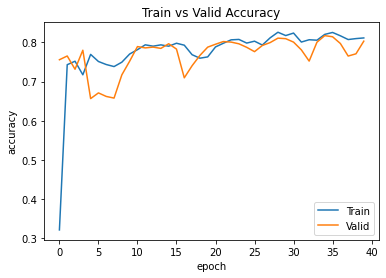

In [7]:
train_accu = []
test_accu = []

def testModel():
    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    for epoch in range(0, 40):
        train_accu.append(train(args, model, device, train_loader, optimizer, epoch).item())
        test_accu.append(test(args, model, device, test_loader).item())
        
testModel()

plt.plot(train_accu)
plt.plot(test_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()